# Práctica 2 - Ejercicio 3: Predicción de Energía con Series Temporales Multivariantes

**Asignatura**: Machine Learning, 2025/2026

**Profesora**: Jose Tomas, Palma Mendez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Lectura y Preparación de Datos](#lectura)
3. [Modelo Línea Base](#linea-base)
4. [Estrategia de Evaluación](#eval)
5. [Modelos Avanzados con Grid Search](#modelos)
   1. [Random Forest](#random)
   2. [XGBoost](#xgboost)
   3. [SVR](#svr)
6. [Comparación y Conclusiones](#conclu)

 [Uso de IA Generativa](#genia)

 [Entorno de Ejecución](#entorno)

## Introducción <a class="anchor" id="intro"></a>

En este notebook vamos a realizar el ejercicio 2.3 de predicción de energía con series temporales multivariables. En terminos generales vamos a continuar con los mismos algoritmos y estrategias que en el ejercicio anterior pero con estrategias multivariables


## Lectura y Preparación de Datos <a class="anchor" id="lectura"></a>

En esta sección se cargan los datos previamente preprocesados y analizados en el notebook `practica2_ejercicio1.ipynb`

In [2]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Skforecast para series temporales multivariantes
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, grid_search_forecaster_multiseries

## Graficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# CONSTANTES
TARGET = 'Energía total (kWh)'
HORIZONTE = 7  # días
LAGS = 7  # días
SEED= 42

# Definir diferentes configuraciones de lags
lags_grid = [7]

Primero cargamos todas las librerías y las constantes que utilizaremos durante el resto del notebook

In [3]:
# Cargar datos
energia_preprocesada = pd.read_csv('energia_preprocesada.csv', index_col=0, parse_dates=True)
# Establecer frecuencia diaria
energia_preprocesada = energia_preprocesada.asfreq('D')

display(energia_preprocesada.head())

,Día de la semana,Electricidad (kW),Fotovoltaica (kW),Refrigeración (kW),Calefacción (kWh),Energía total (kWh),Emisión (kg CO₂)
2014-01-01,2,490049.28,62795.47,243369.71770,20107.60131,753526.59901,469960.0
2014-01-02,3,556486.56,64284.00,323886.05169,23987.86135,904360.47304,564020.0
2014-01-03,4,545831.45,67187.06,337004.60237,22112.20695,904948.25932,564390.0
2014-01-04,5,511495.56,46798.28,252493.06189,21074.73561,785063.35750,489640.0
2014-01-05,6,502806.80,70162.87,249265.37031,22777.47812,774849.64843,483270.0


Vamos a dividir el dataset en train y test, para ello hemos elegido la estrategia de hold out con 80, 20 ya que es estandar en la industria. Además es la misma estrategía que utilizamos en el ejercicio 2.

In [4]:
# División train/test 80/20
train_index = int(len(energia_preprocesada) * 0.8)
train_data = energia_preprocesada.iloc[:train_index]
train_data = train_data.asfreq('D')
test_data = energia_preprocesada.iloc[train_index:]
test_data = test_data.asfreq('D')

Vamos a representar las distintas variables en una gráfica con la partición de train y test.

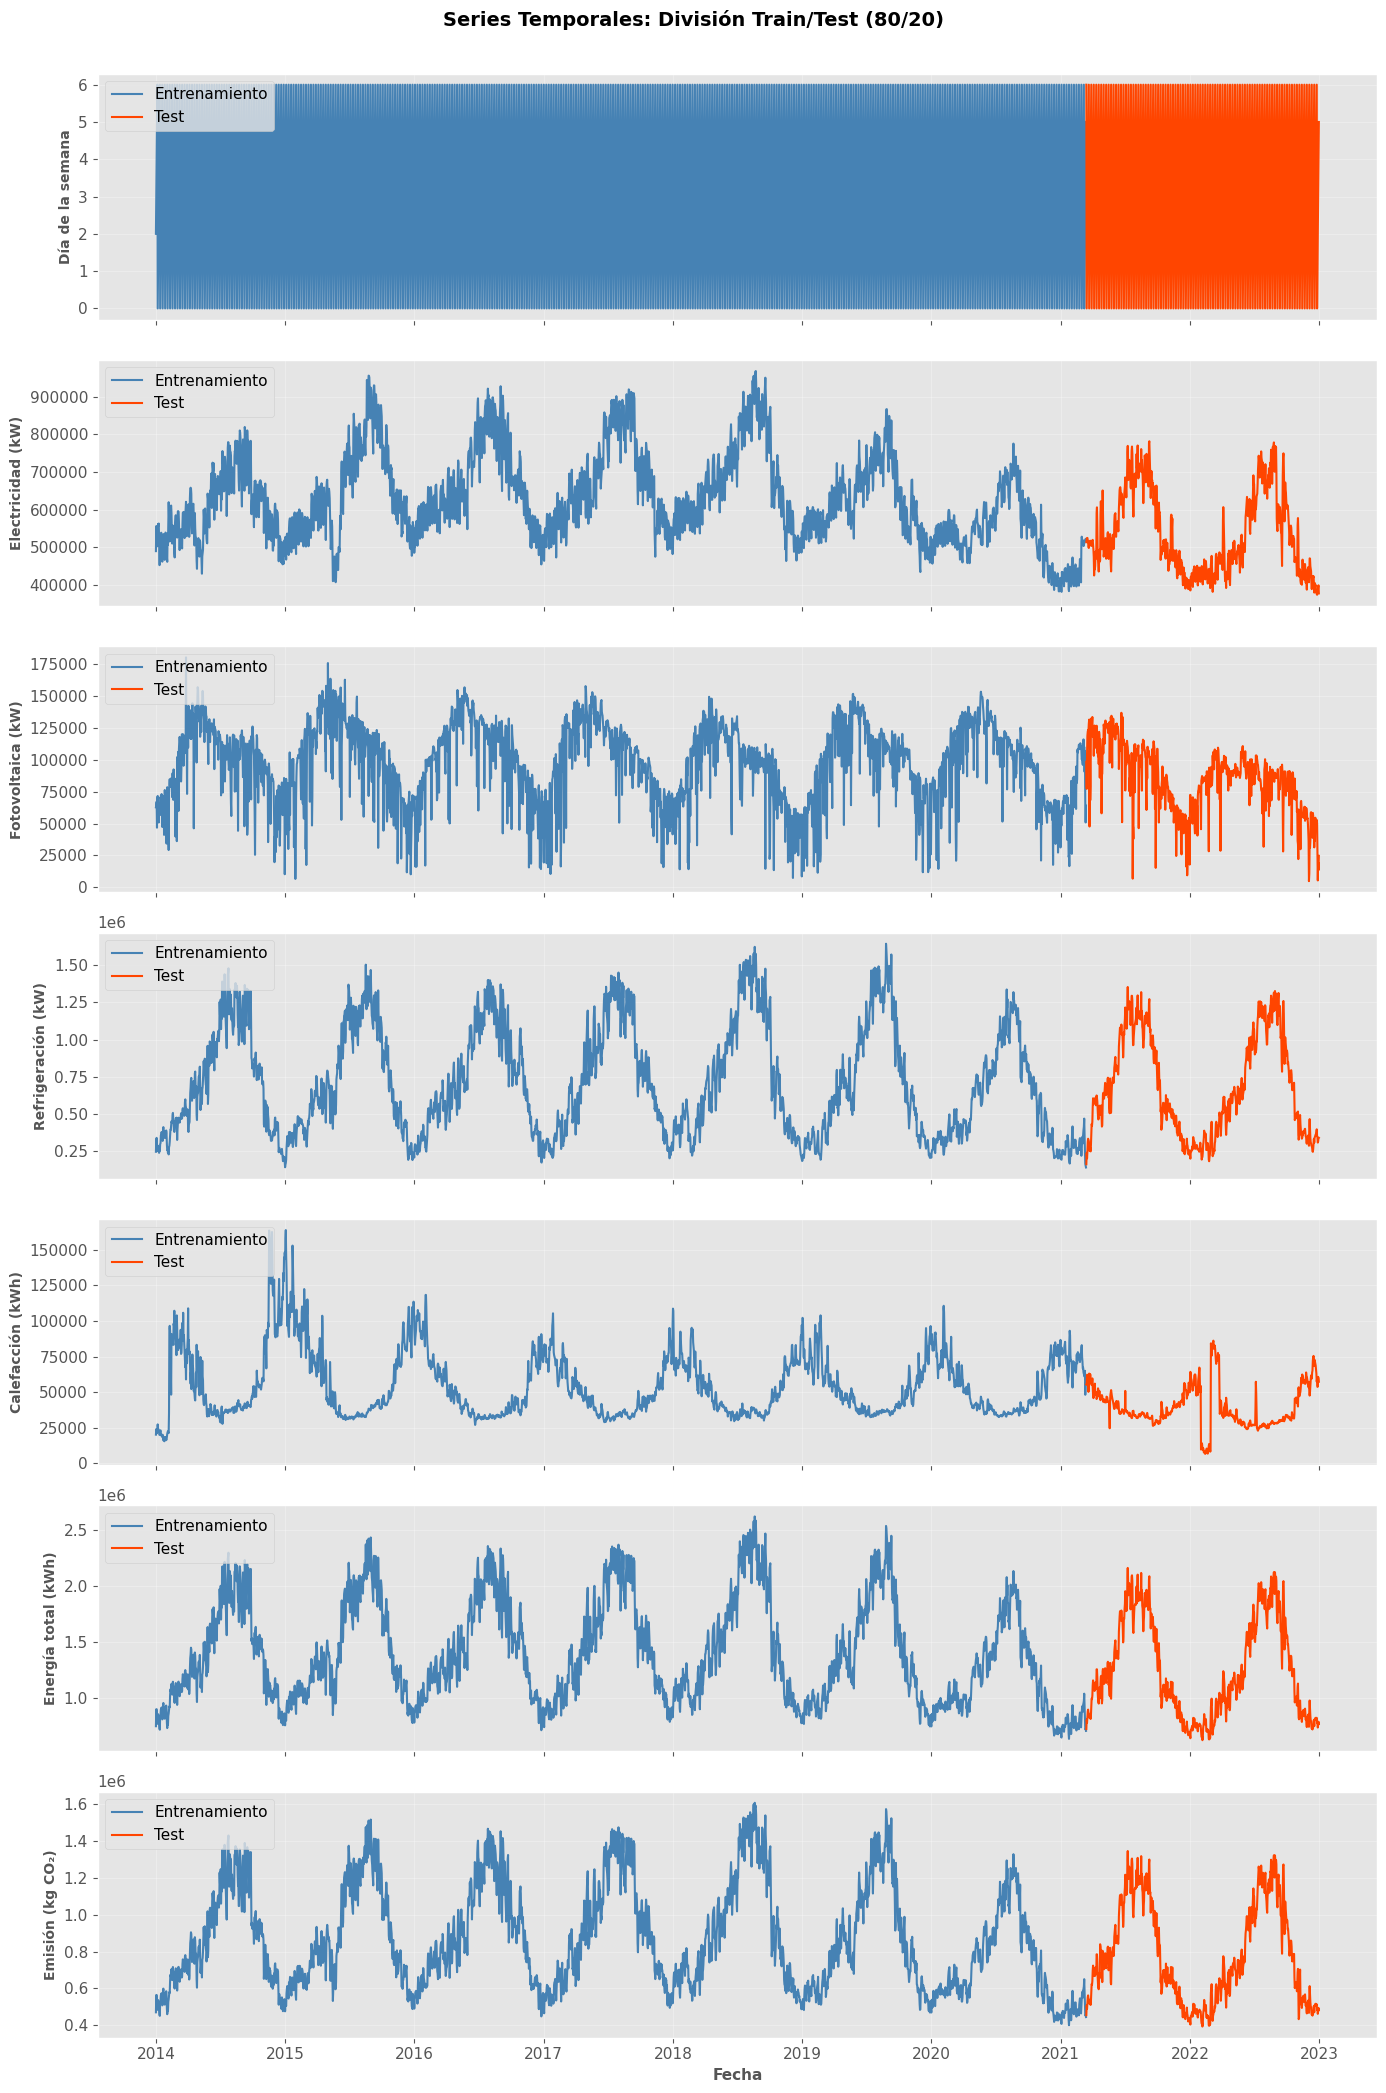

In [5]:
# Visualización de la división train/test
n_series = len(energia_preprocesada.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(14, 3*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for i, col in enumerate(energia_preprocesada.columns):
    ax = axes[i]
    ax.plot(train_data.index, train_data[col], color='steelblue', label='Entrenamiento', linewidth=1.5)
    ax.plot(test_data.index, test_data[col], color='orangered', label='Test', linewidth=1.5)
    ax.set_ylabel(col, fontsize=10, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
fig.suptitle('Series Temporales: División Train/Test (80/20)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## 2. Modelo Línea Base <a class="anchor" id="linea-base"></a>

Vamos a utilizar un LightGBM como modelo base, es un modelo rápido que nos podrá dar una aproximación de la calidad de los datos. Es tambien el mismo que modelo base que se utilizo en el ejercicio anterior. 
Tambien mantenemos la estrategia de aplicar un enfoque Recursive, ya que los datos presentan una fuerte estacionalidad y la comparación con uni variable será más directa. 


**Configuración:**
Utilizaremos los parámetros por defecto, con un hold out 80/20 para el primer modelo base, con un horizonte de 7 días.

In [6]:
# Crear forecaster con LightGBM
baseline_forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(random_state=SEED, verbose=-1),
    lags=LAGS,
    encoding='onehot'
)
baseline_forecaster.fit(series=train_data)

Vamos a visualizar los primeros 7 días predichos con GT para comprobar graficamente como funciona el modelo base.

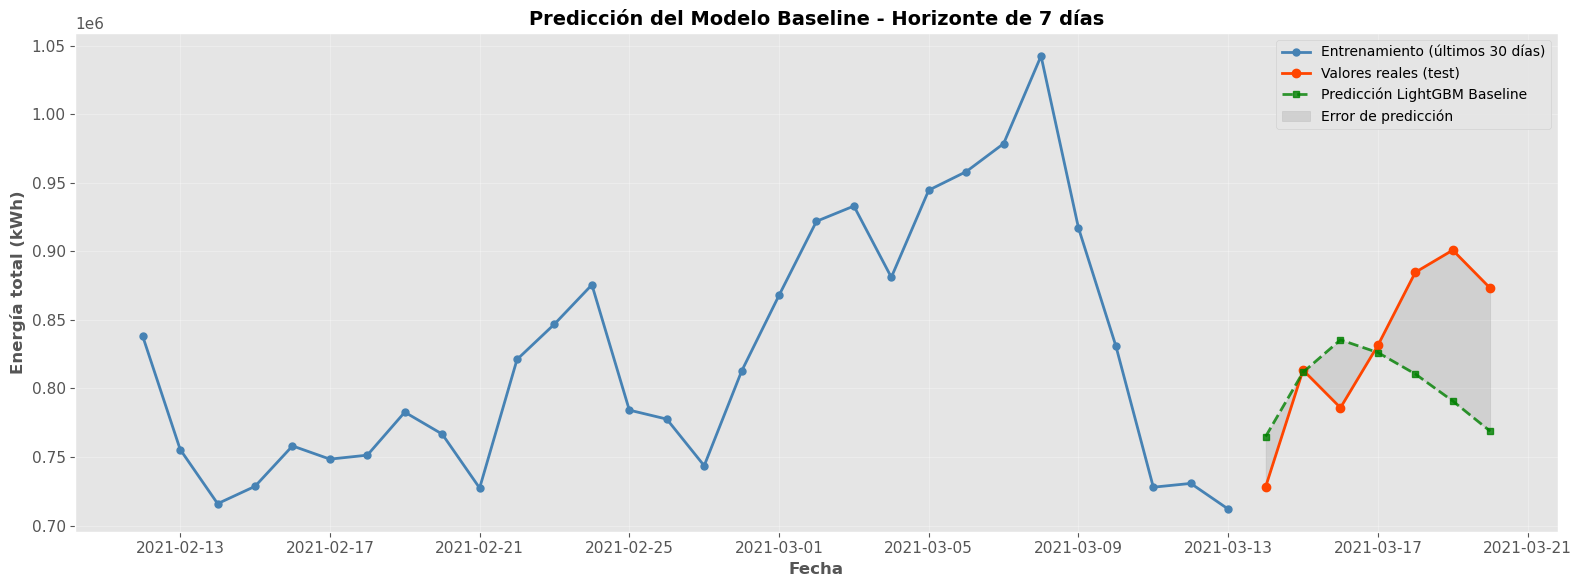


Métricas de la predicción inicial (primeros 7 días):
  • MAE  = 54496.578 kW
  • RMSSE = 1.409 kW
  • R²   = -0.4398


In [7]:
# Predecir los próximos 7 días a partir del final del train
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET)

# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train_data[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test_data[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

Se puede ver que los resultados son buenos para los primeros 2 días y despues se produce una desviación de más intensas en el tercer, quinto, sexto y septimo día.

## Estrategia de Evaluación <a class="anchor" id="eval"></a>

Para la evaluación vamos a utilziar las mismas métricas que utilizamos en el notebook anterior, R², MAE y RMSE. Estas métricas las utilizaremos con el conjunto de Test, tambien vamos a utilziar Bactesting para comprobar la generalización y overfiting del modelo.

In [8]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo", verbose=True):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calcular RMSSE (Root Mean Squared Scaled Error)
    # Escala usando las diferencias consecutivas de la serie real
    scale = np.mean(np.diff(y_true)**2)
    mse = mean_squared_error(y_true, y_pred)
    rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'R²': r2,
        'RMSSE': rmsse
    }
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")    
        print(f"  • R²    = {r2:.4f}")    
        print(f"  • RMSSE = {rmsse:.4f}")
    return resultados

La función anterior genera las métricas  R², MAE y RMSSE para un resultado real y los predichos.

### Estrategia de Evaluación con TimeSeriesFold:
El objeto TimeSeriesFold sería realizar una validación cruzada sobre el conjunto de train, con esto podrémos controlar el overfitting, hemos elegido que comience con un año de datos iniciales de 3 años y que tenga una ventana de un año.

In [9]:
initial_train_size = 365*3  # díasç
window_size = 365
# Crear TimeSeriesFold para backtesting
cv = TimeSeriesFold(
    steps=HORIZONTE,                  # Horizonte de predicción
    initial_train_size=initial_train_size,  # Inicial de 365 días
    window_size=window_size,                 # Ventana fija de 7 días
    fold_stride           = None,
    refit=False,                      # No reentrenar en cada fold
    fixed_train_size=True,           # Ventana fija
    gap=0,                            # Sin gap entre train y test
    allow_incomplete_fold=True,       # Permitir folds incompletos
)
cv.split(X=train_data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,1095,730,1095,1095,1102,1095,1102,True
1,1,0,1095,737,1102,1102,1109,1102,1109,False
2,2,0,1095,744,1109,1109,1116,1109,1116,False
3,3,0,1095,751,1116,1116,1123,1116,1123,False
4,4,0,1095,758,1123,1123,1130,1123,1130,False
...,...,...,...,...,...,...,...,...,...,...
215,215,0,1095,2235,2600,2600,2607,2600,2607,False
216,216,0,1095,2242,2607,2607,2614,2607,2614,False
217,217,0,1095,2249,2614,2614,2621,2614,2621,False
218,218,0,1095,2256,2621,2621,2628,2621,2628,False


In [10]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_baseline, predicciones_bt_baseline = backtesting_forecaster_multiseries(
    forecaster=baseline_forecaster,
    series=train_data,  # Serie completa
    cv=cv,                         # Usar TimeSeriesFold
    levels=TARGET,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_baseline = train_data[TARGET].values[initial_train_size:]

y_pred_baseline = predicciones_bt_baseline.values[:,1]

# Calcular métricas completas (MAE, RMSE, R²)
metricas_baseline = calcular_metricas(y_true_baseline, y_pred_baseline, "LightGBM Baseline")


resultados_modelos_cv = [metricas_baseline]


Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de LightGBM Baseline:
  • MAE   = 1382502.186 kWh
  • R²    = -8.5619
  • RMSSE = 14.9712


Podemos ver que los resultados para nuestro modelo base son los siguientes: MAE de 1382502.186 KW, R² de -8.5619, este valor suele estar entre 0 y 1 si el valor es negativo denota un error muy alto. Por último el RMSSE es de 14.9

## Modelos Avanzados con Grid Search <a class="anchor" id="modelos"></a>

En esta sección entrenamos tres modelos más avanzados mediante búsqueda de hiperparámetros, los mismos 3 modelos que usamos en el notebook anterior:

- **Random Forest**: Ensemble de árboles de decisión, robusto y efectivo
- **XGBoost**: Gradient boosting optimizado, muy potente en competiciones
- **SVR**: Support Vector Regression, captura relaciones no lineales



### Random Forest con Grid Search <a class="anchor" id="random"></a>

Vamos a utilizar en Random Forest los siguientes parametros:

`n_estimators`: 50, 150

`max_depth`: 10, 20

`min_samples_split`: 2, 5

`min_samples_leaf`: 1, 2

Vamos a probar parámetros pequeños para no sobre ajustar demasiado, hay que tener en cuenta que el modelo utilizará todos los lags como variables para predecir.

In [11]:
# Crear forecaster
rf_forecaster = ForecasterRecursiveMultiSeries(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Ejecutar grid search con cv específico para validación interna
results_rf = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,
    param_grid=param_grid_rf,
    lags_grid=lags_grid,
    cv=cv,  
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
  Backtesting metric: 51005.40663461236
  Levels: ['Día de la semana', 'Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)', 'Emisión (kg CO₂)']



Podemos ver que los mejores parámetros han sido: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150} salvo para n_estimators los valores más bajos han dado mejores resultados. Se podría probar en el futuro añadir más n_estimators para ver si mejora el resultado con más arboles

In [12]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_rf, predicciones_bt_rf = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,  # Serie completa
    cv=cv,                         # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_baseline = train_data[TARGET].values[initial_train_size:]

y_pred_baseline = predicciones_bt_rf['pred'].values

# Calcular métricas completas (MAE, RMSE, R²)
metricas_rf = calcular_metricas(y_true_baseline, y_pred_baseline, "Random Forest")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_rf)


Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Random Forest:
  • MAE   = 124161.269 kWh
  • R²    = 0.8787
  • RMSSE = 1.6865


Encuanto a los resultados ahora tenemos unos valores mejores en todas las métricas en comparación con el modelo base, R² está entre 0 y 1 como se espera.

### XGBoost con Grid Search <a class="anchor" id="xgboost"></a>

Para XGBoost vamos a usar los siguientes parámetros:

`n_estimators`: 50, 100

`max_depth`: 3, 10

`learning_rate`: 0.01, 0.1

`subsample`: 0.8, 1.0

`colsample_bytree`: 0.8, 1.0

In [13]:
# Crear forecaster
xgb_forecaster = ForecasterRecursiveMultiSeries(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}



# Ejecutar grid search con cv específico para validación interna
results_xgb = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid,
    cv=cv,  # Usar cv específico para grid search
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/32 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  Backtesting metric: 49947.94483303839
  Levels: ['Día de la semana', 'Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)', 'Emisión (kg CO₂)']



Para XGBoost los mejores parámetros han sido  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}. Un mayor learning rate y numero de estimadores ha dado mejores resultados.

In [14]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_xgb, predicciones_bt_xgb = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,  # Serie completa
    cv=cv,                         # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_xgb = train_data[TARGET].values[initial_train_size:]

y_pred_xgb = predicciones_bt_xgb['pred'].values

# Calcular métricas completas (MAE, RMSE, R²)
metricas_xgb = calcular_metricas(y_true_xgb, y_pred_xgb, "XGBoost")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_xgb)

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de XGBoost:
  • MAE   = 122103.022 kWh
  • R²    = 0.8814
  • RMSSE = 1.6673


XGBoost mejora ligeramente los resultados del random forest.

### SVR con Grid Search <a class="anchor" id="svr"></a>

Para SVR vamos a usar los siguientes parámetros:

`kernel`: 'rbf', 

`C`: 0.1. 10

`epsilon`: 0.01, 0.5

`gamma`: 'scale'

In [15]:
# Crear forecaster
svr_forecaster = ForecasterRecursiveMultiSeries(
    regressor=SVR(),
    lags=LAGS,
    encoding='onehot'
)

# Definir grilla de hiperparámetros
param_grid_svr = {
    'kernel': ['rbf'],
    'C': [0.1, 10 ],
    'epsilon': [0.01, 0.5],
    'gamma': ['scale',]
}


# Ejecutar grid search con cv específico para validación interna
results_svr = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data,
    param_grid=param_grid_svr,
    lags_grid=lags_grid,
    cv=cv,  # Usar cv específico para grid search
    metric='mean_absolute_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
  Backtesting metric: 427575.57771432045
  Levels: ['Día de la semana', 'Electricidad (kW)', 'Fotovoltaica (kW)', 'Refrigeración (kW)', 'Calefacción (kWh)', 'Energía total (kWh)', 'Emisión (kg CO₂)']



Un mayor C y menor epsilon ha dado a priori mejores resultados.

In [16]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_svr, predicciones_bt_svr = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data,  # Serie completa
    cv=cv,                         # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error'],
    n_jobs='auto',
    verbose=True,
    show_progress=True
)

y_true_svr = train_data[TARGET].values[initial_train_size:]

y_pred_svr = predicciones_bt_svr['pred'].values

# Calcular métricas completas (MAE, RMSE, R²)
metricas_svr = calcular_metricas(y_true_svr, y_pred_svr, "Support Vector Regression")

# Guardar resultados para comparación posterior
resultados_modelos_cv.append(metricas_svr)


Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

  0%|          | 0/220 [00:00<?, ?it/s]


Métricas de Support Vector Regression:
  • MAE   = 846853.709 kWh
  • R²    = -3.2231
  • RMSSE = 9.9495


Este modelo da peores resultados que Random Forest y XGBoost, puede ser por el Grid Search de parámetros que es más reducido que el de los otros dos modelos.

## Comparación y Conclusiones <a class="anchor" id="conclu"></a>

En esta sección final comparamos todos los modelos entrenados y presentamos las conclusiones más relevantes del análisis.

In [17]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))


TABLA DE RESULTADOS (ordenado por RMSSE):

                   Modelo          MAE        R²     RMSSE
                  XGBoost 1.221030e+05  0.881409  1.667288
            Random Forest 1.241613e+05  0.878654  1.686543
Support Vector Regression 8.468537e+05 -3.223147  9.949519
        LightGBM Baseline 1.382502e+06 -8.561877 14.971164

Mejora respecto al baseline: 88.86% en RMSSE


,Modelo,MAE,R²,RMSSE
2,XGBoost,122103.022,0.8814,1.6673
1,Random Forest,124161.269,0.8787,1.6865
3,Support Vector Regression,846853.709,-3.2231,9.9495
0,LightGBM Baseline,1382502.186,-8.5619,14.9712


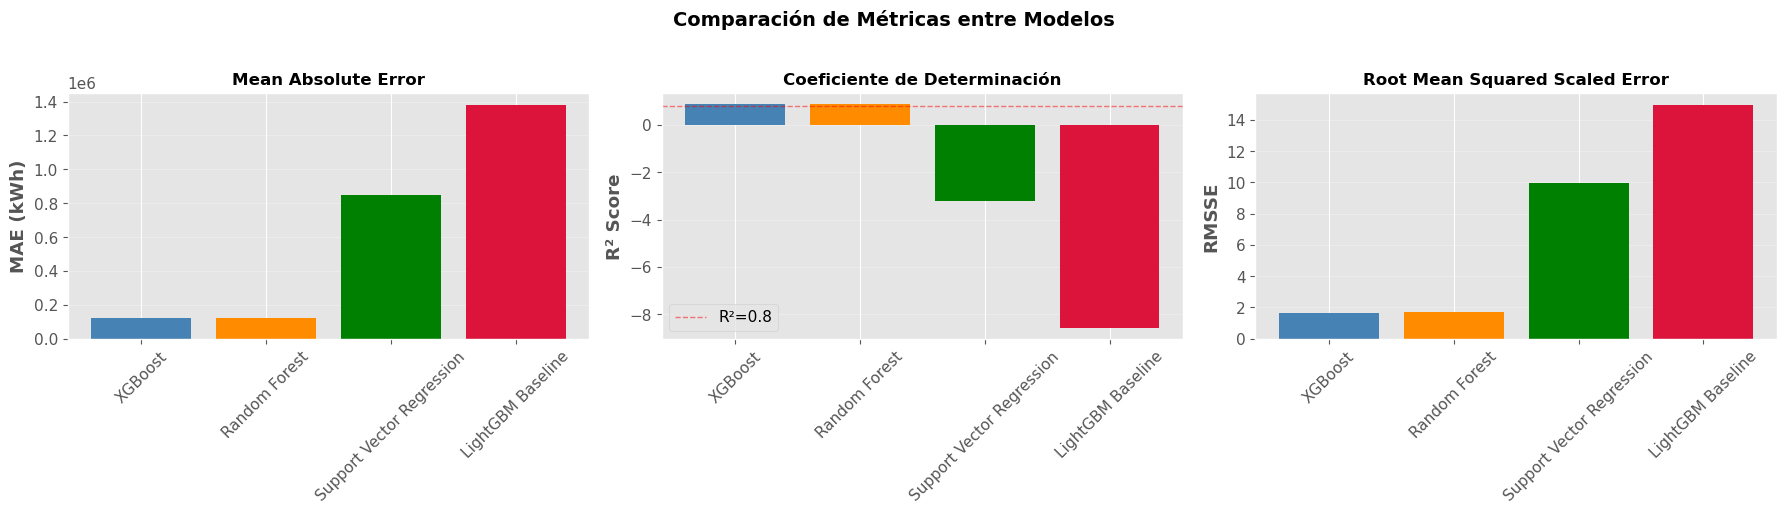

In [18]:
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Uso de IA Generativa <a class="anchor" id="genia"></a>


**Prompt**: En base a un dataframe con las siguientes columnas Modelo, MAE, R2 y RMSSE, crea una visualización con diagrama de barras de los distintos errores, por modelo. 
Además crea una tabla con los valores ordenados por RMSSE para ver que modelo funciona mejor.

```Python

print("\n📈 GRÁFICA COMPARATIVA DE MÉTRICAS:")

# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))
```
**Prompt**: Crea una gráfica para mostrar los resultados de predicción del siguiente modelo:
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET)
con HORIZONTE=7 y TARGET = Energía total (kWh). Ten en cuenta que quiero mostrar los 30 días anteriores a la predicción y el resultado predicho y el resultado original. Calcula tambien el MAE, RMSSE y R2.

**Consideraciones**: El código se tuvo  que adaptar, principalmente nombres de variales y accesos a diccionraios
```Python
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial.value, 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial.value,
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

```


## Entorno de Ejecución <a class="anchor" id="entorno"></a>

In [ ]:
import sklearn
sklearn.show_versions()

In [ ]:
from sinfo import sinfo

sinfo()